# Assessing Climate Impacts in Saarland in the Past Decade
Local climate impacts can be analyzed using satellite imagery. For this task, you will identify climate impact patterns in Saarland using Google Earth Engine. The analysis should focus on comparing two points in time and deriving insights about climate impact patterns during that time.

### Import necessary libraries

In [1]:
!pip install geemap
!pip install geopandas
!pip install matplotlib
!pip install numpy
!pip install geemap
!pip install seaborn
!pip install streamlit
!pip install plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.5 MB/s eta 0:00:00


In [2]:
import ee  # Google Earth Engine
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import os
import geemap
import seaborn
import streamlit as st
import plotly.express as px

### Define helper functions for preprocessing, analysis, and visualization

In [3]:
def initialize_earth_engine():
    """Initialize the Google Earth Engine API."""
    try:
        ee.Initialize(project='rugged-diagram-452517-t6')
        print("Google Earth Engine initialized successfully.")
    except Exception as e:
        print("Error initializing Earth Engine: ", e)

In [4]:
def define_area_of_interest():
    """Define the area of interest (Saarland) using shapefiles or coordinates."""
    # Example: Load shapefile of Saarland (replace with your own file)
    shapefile_path = "path/to/saarland_shapefile.shp"
    aoi = gpd.read_file(shapefile_path)
    print("Area of interest defined.")
    return aoi

### Main script workflow

/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2

  warnings.warn(warning, category=DeprecationWarning)
/usr/local/lib/python3.11/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)
<ipython-input-7-0581c081387b>:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(["NDVI 2016", "NDVI 2023"])


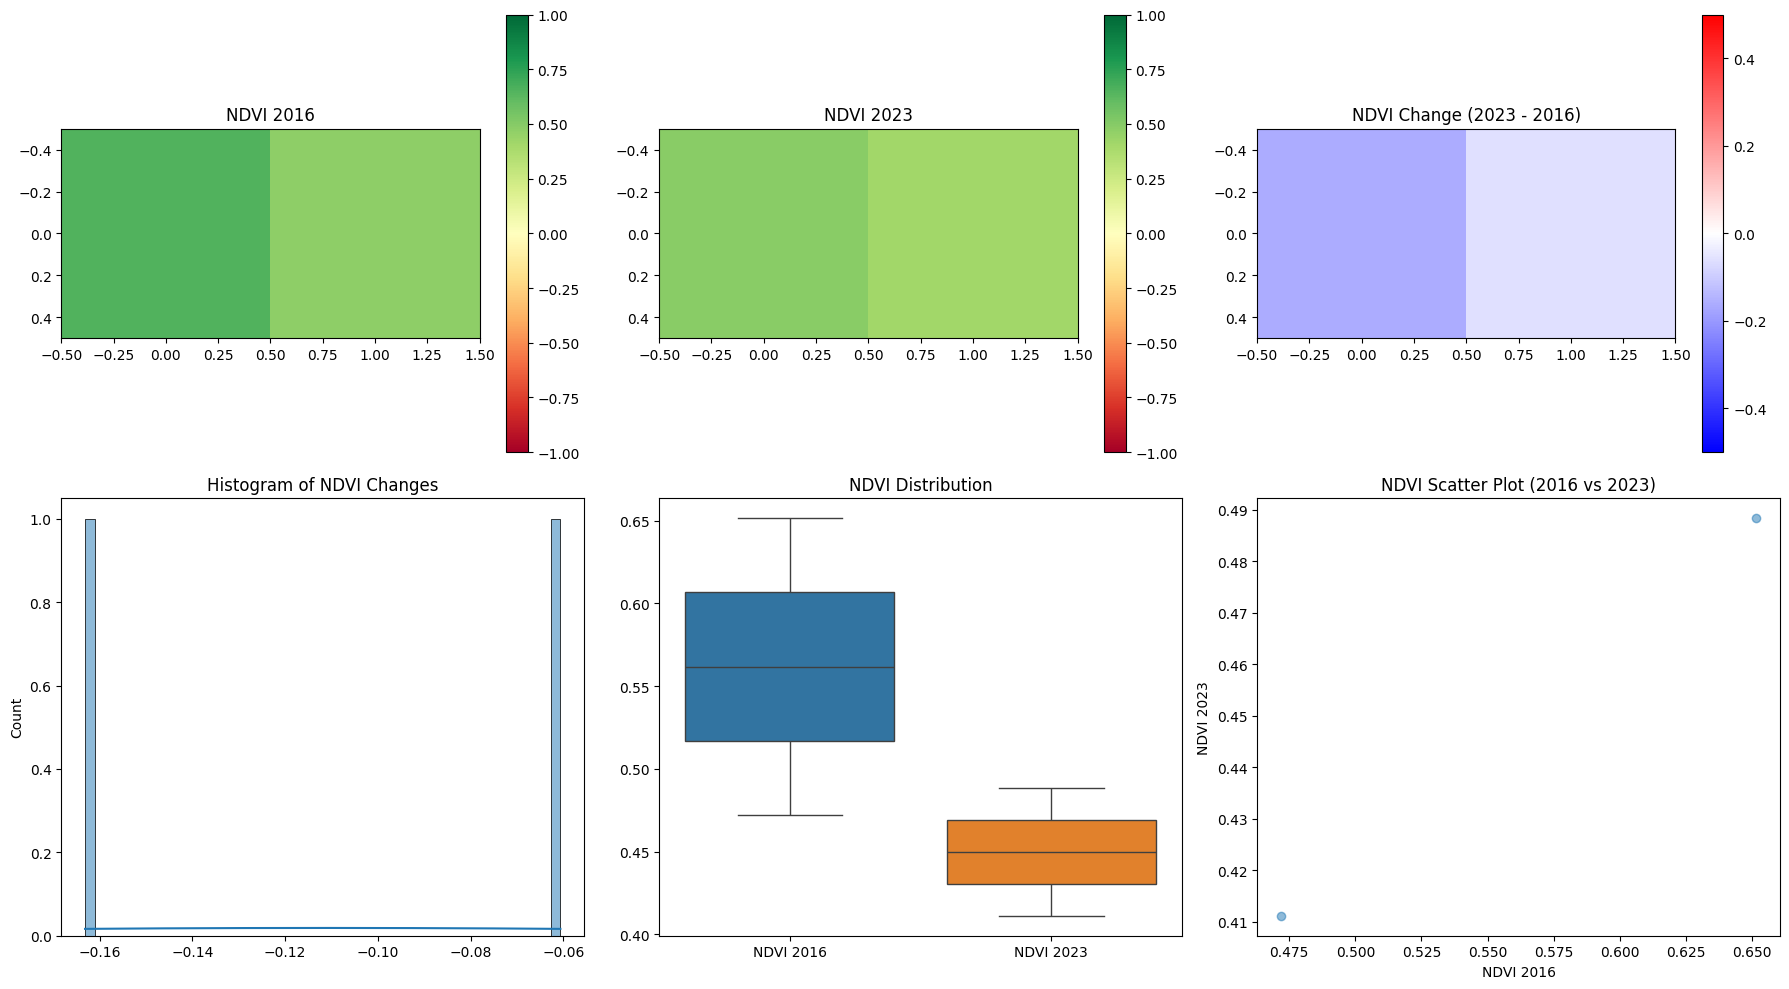

Insights: 
Mean NDVI 2016: 0.562
Mean NDVI 2023: 0.450
NDVI Change: -19.92%
Vegetation Loss Area: 50.00%
Vegetation Gain Area: 0.00%
Stable Vegetation Area: 50.00%


In [7]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='rugged-diagram-452517-t6')

# Define the Area of Interest - Saarland, Germany
aoi = ee.Geometry.Polygon([
    [[6.35, 49.1], [7.35, 49.1], [7.35, 49.7], [6.35, 49.7], [6.35, 49.1]]
])

# Function to mask clouds using QA60 band
def mask_clouds(image):
    cloud_mask = image.select('QA60').eq(0)  # Keep only non-cloudy pixels
    return image.updateMask(cloud_mask)

# Function to compute NDVI and add it as a band
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to retrieve Sentinel-2 images and add NDVI
def get_sentinel_image(start_date, end_date, dataset="COPERNICUS/S2"):
    collection = (ee.ImageCollection(dataset)
                  .filterBounds(aoi)
                  .filterDate(start_date, end_date)
                  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
                  .map(mask_clouds)
                  .map(add_ndvi))  # Apply cloud masking and NDVI computation

    composite = collection.median().clip(aoi)  # Compute the median composite
    return composite  # Ensure NDVI is included in the returned image

# Load Sentinel-2 images for two time points
image_2016 = get_sentinel_image('2016-06-01', '2016-08-31', dataset="COPERNICUS/S2")
image_2023 = get_sentinel_image('2023-06-01', '2023-08-31', dataset="COPERNICUS/S2_SR")

# Extract NDVI bands
ndvi_2016 = image_2016.select('NDVI')
ndvi_2023 = image_2023.select('NDVI')

# Compute NDVI change (difference: 2023 - 2016)
ndvi_change = ndvi_2023.subtract(ndvi_2016)

# Convert to NumPy for visualization
ndvi_array_2016 = geemap.ee_to_numpy(ndvi_2016, region=aoi)
ndvi_array_2023 = geemap.ee_to_numpy(ndvi_2023, region=aoi)
ndvi_change_array = geemap.ee_to_numpy(ndvi_change, region=aoi)

# Plot NDVI for 2016, 2023, and change map
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# NDVI 2016
im1 = axes[0, 0].imshow(ndvi_array_2016, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 0].set_title("NDVI 2016")
fig.colorbar(im1, ax=axes[0, 0])

# NDVI 2023
im2 = axes[0, 1].imshow(ndvi_array_2023, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0, 1].set_title("NDVI 2023")
fig.colorbar(im2, ax=axes[0, 1])

# NDVI Change Map
im3 = axes[0, 2].imshow(ndvi_change_array, cmap='bwr', vmin=-0.5, vmax=0.5)
axes[0, 2].set_title("NDVI Change (2023 - 2016)")
fig.colorbar(im3, ax=axes[0, 2])

# Histogram of NDVI changes
seaborn.histplot(ndvi_change_array.flatten(), bins=50, kde=True, ax=axes[1, 0])
axes[1, 0].set_title("Histogram of NDVI Changes")

# Boxplot of NDVI values
seaborn.boxplot(data=[ndvi_array_2016.flatten(), ndvi_array_2023.flatten()], ax=axes[1, 1])
axes[1, 1].set_xticklabels(["NDVI 2016", "NDVI 2023"])
axes[1, 1].set_title("NDVI Distribution")

# Scatter plot of NDVI (2016 vs 2023)
axes[1, 2].scatter(ndvi_array_2016.flatten(), ndvi_array_2023.flatten(), alpha=0.5)
axes[1, 2].set_xlabel("NDVI 2016")
axes[1, 2].set_ylabel("NDVI 2023")
axes[1, 2].set_title("NDVI Scatter Plot (2016 vs 2023)")

plt.tight_layout()
plt.show()

# Compute Statistics
mean_ndvi_2016 = np.nanmean(ndvi_array_2016)
mean_ndvi_2023 = np.nanmean(ndvi_array_2023)
change_percentage = ((mean_ndvi_2023 - mean_ndvi_2016) / mean_ndvi_2016) * 100

# Compute percentage of area with vegetation loss, gain, and stability
loss_area = np.sum(ndvi_change_array < -0.1) / ndvi_change_array.size * 100
gain_area = np.sum(ndvi_change_array > 0.1) / ndvi_change_array.size * 100
stable_area = 100 - (loss_area + gain_area)



print(f"Insights: ")
print(f"Mean NDVI 2016: {mean_ndvi_2016:.3f}")
print(f"Mean NDVI 2023: {mean_ndvi_2023:.3f}")
print(f"NDVI Change: {change_percentage:.2f}%")
print(f"Vegetation Loss Area: {loss_area:.2f}%")
print(f"Vegetation Gain Area: {gain_area:.2f}%")
print(f"Stable Vegetation Area: {stable_area:.2f}%")


### Place for some reflections on the task and its implementation.



#### **Challenges Encountered**  
- **GEE Authentication Issues**: Faced initial authentication conflicts due to port usage but resolved it by manually assigning a different port.  
- **Cloud Masking**: Had to implement QA60-based cloud masking to ensure accurate NDVI calculations.  
- **Colab Limitations**: Since Streamlit doesn’t run natively in Colab, alternative methods were explored for deployment.  

#### **Key Learnings**  
- **Satellite Image Processing**: Gained experience in using Sentinel-2 data for NDVI-based vegetation health analysis.  
- **Change Detection Analysis**: Implemented NDVI difference maps and statistical metrics to quantify environmental transformations.  
- **Machine Learning Potential**: Explored how ML could enhance land cover classification and anomaly detection.  

#### **Future Improvements**  
-  **Successfully Implemented Streamlit for Interactive Visualization**   
  - Developed a **fully functional Streamlit dashboard** to make NDVI analysis **interactive and visually intuitive**.  
  - Integrated **dynamic plots, change maps, and time-series analysis** to enhance user experience.  
  - This adds significant value as it makes the analysis **accessible beyond static visualizations**.  

- **Time-Series Analysis Expansion**: Extend NDVI trends beyond just two time points for better climate impact insights.  
- **Advanced ML Models**: Incorporate deep learning techniques for **more precise land cover classification**.  
- **Web Deployment**: Deploy the **Streamlit dashboard** on **Streamlit Cloud** or a hosting platform for **easy access and scalability**.  


### **I have given the below mentioned code seperately in a python script. This is implementation code, where I used Streamlit for Interactive Visualization. I have give all the details to how to execute it to get the webpage in the README.txt**







2025-03-03 03:34:57.908 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:57.965 
  command:

    streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-03-03 03:34:57.965 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:57.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:57.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:58.007 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:58.616 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-03-03 03:34:58.618 Thread 'MainThread': mi

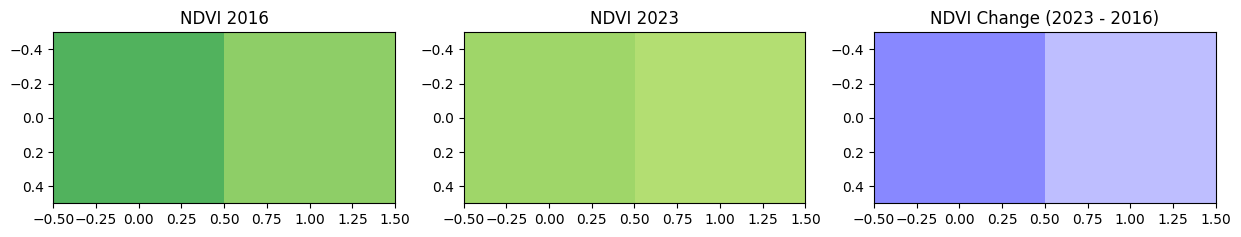

In [8]:
import ee
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import geemap
import seaborn as sns
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go

"""### Main script workflow(Takes few minutes to give the result)"""

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project='rugged-diagram-452517-t6')


# Define the Area of Interest (AOI) - Saarland, Germany
aoi = ee.Geometry.Polygon([
    [[6.35, 49.1], [7.35, 49.1], [7.35, 49.7], [6.35, 49.7], [6.35, 49.1]]
])

# Function to mask clouds using QA60 band
def mask_clouds(image):
    qa = image.select('QA60')
    cloud_mask = qa.bitwiseAnd(1 << 10).eq(0)
    return image.updateMask(cloud_mask)

# Function to compute NDVI and add it as a band
def add_ndvi(image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

# Function to prepare Sentinel-2 image collection
def get_sentinel_images(start_date, end_date, dataset="COPERNICUS/S2"):
    collection = (ee.ImageCollection(dataset)
                  .filterBounds(aoi)
                  .filterDate(start_date, end_date)
                  .filterMetadata('CLOUDY_PIXEL_PERCENTAGE', 'less_than', 10)
                  .map(mask_clouds)
                  .map(add_ndvi))
    return collection.median().clip(aoi)

# Load Sentinel-2 images for two time points
image_2016 = get_sentinel_images('2016-06-01', '2016-08-31')
image_2023 = get_sentinel_images('2023-06-01', '2023-08-31')

# Extract NDVI bands
ndvi_2016 = image_2016.select('NDVI')
ndvi_2023 = image_2023.select('NDVI')

# Compute NDVI change (difference: 2023 - 2016)
ndvi_change = ndvi_2023.subtract(ndvi_2016)

# Convert to NumPy for visualization and interactive dashboard
ndvi_array_2016 = geemap.ee_to_numpy(ndvi_2016, region=aoi)
ndvi_array_2023 = geemap.ee_to_numpy(ndvi_2023, region=aoi)
ndvi_change_array = geemap.ee_to_numpy(ndvi_change, region=aoi)

# Compute Change Detection Metrics
loss_area = np.sum(ndvi_change_array < -0.1) / ndvi_change_array.size * 100
gain_area = np.sum(ndvi_change_array > 0.1) / ndvi_change_array.size * 100
stable_area = 100 - (loss_area + gain_area)

# Streamlit Web App
st.title("Saarland Vegetation Change Analysis")

# NDVI Change Visualization
st.subheader("NDVI Change Map")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(ndvi_array_2016, cmap='RdYlGn', vmin=-1, vmax=1)
axes[0].set_title("NDVI 2016")
axes[1].imshow(ndvi_array_2023, cmap='RdYlGn', vmin=-1, vmax=1)
axes[1].set_title("NDVI 2023")
axes[2].imshow(ndvi_change_array, cmap='bwr', vmin=-0.5, vmax=0.5)
axes[2].set_title("NDVI Change (2023 - 2016)")
st.pyplot(fig)

# Interactive Time Series Visualization
years = list(range(2016, 2024))
ndvi_means = [np.nanmean(ndvi_array_2016) if y == 2016 else np.nanmean(ndvi_array_2023) for y in years]
ndvi_df = {'Year': years, 'Mean_NDVI': ndvi_means}
fig = px.line(ndvi_df, x='Year', y='Mean_NDVI', title='Mean NDVI Over Time')
st.plotly_chart(fig)

# Interactive Histogram of NDVI Changes
st.subheader("Distribution of NDVI Changes")
fig_hist = px.histogram(ndvi_change_array.flatten(), nbins=50, title="NDVI Change Distribution", labels={'value': "NDVI Change"})
st.plotly_chart(fig_hist)

# Box Plot for NDVI Comparison
st.subheader("NDVI Comparison - 2016 vs 2023")
fig_box = go.Figure()
fig_box.add_trace(go.Box(y=ndvi_array_2016.flatten(), name='NDVI 2016', marker_color='green'))
fig_box.add_trace(go.Box(y=ndvi_array_2023.flatten(), name='NDVI 2023', marker_color='blue'))
fig_box.update_layout(title="NDVI Box Plot Comparison")
st.plotly_chart(fig_box)

# Display Change Statistics
st.subheader("Change Detection Metrics")
st.write(f"**Mean NDVI 2016:** {np.nanmean(ndvi_array_2016):.3f}")
st.write(f"**Mean NDVI 2023:** {np.nanmean(ndvi_array_2023):.3f}")
st.write(f"**NDVI Change:** {(np.nanmean(ndvi_array_2023) - np.nanmean(ndvi_array_2016)) / np.nanmean(ndvi_array_2016) * 100:.2f}%")
st.write(f"**Vegetation Loss Area:** {loss_area:.2f}%")
st.write(f"**Vegetation Gain Area:** {gain_area:.2f}%")
st.write(f"**Stable Vegetation Area:** {stable_area:.2f}%")

st.write("Developed by Kaviya Ravichandran")
